# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
import os
import time
import datetime


import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-3121ccbe-3d4b-3ba9-ce07-af624d3ca998)
GPU 1: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-9807473d-3644-9912-cc3d-05880ab4ef36)
GPU 2: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-94db0646-211f-c99a-ea07-d9859dc5a87b)
GPU 3: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-f5267ef4-d399-295f-b58e-91baa2652af9)
GPU 4: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-66accfdf-33c3-3764-dae1-4c8efaefa2f0)
GPU 5: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-486ef60c-26e5-41c4-7810-29630050ae19)
GPU 6: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-602bcadd-6da5-b336-2e0c-ffabb97367a4)
GPU 7: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-02afb69a-63bc-02a2-a8d8-df52eb0a5226)


# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [3]:
df = pd.read_csv('the-office-lines_scripts_preprocessed.csv')

In [4]:
df.dropna(inplace=True) #remove NA values
bios = df.line_text.copy() #just use the main bio text in this example
bios

0       Michael: All right Jim. Your quarterlies look ...
1       Michael: Yes, I'd like to speak to your office...
2       Michael: I've, uh, I've been at Dunder Mifflin...
3       Michael: People say I am the best boss. They g...
4       Dwight: Shall I play for you? Pa rum pump um p...
                              ...                        
8837    Creed: I saw a friend today. It had been a whi...
8839    Phyllis: Hey, Jim, remember flonkerton when yo...
8840    Kevin: Oscar. Oscar.  I think I   m gay. Oscar...
8841    Creed: And all the faces that I know have that...
8844    Creed: It all seems so very arbitrary. I appli...
Name: line_text, Length: 6719, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/tmp/ipykernel_3422329/3284538386.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

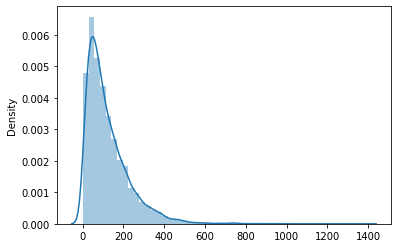

In [5]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [6]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0011906533710373567

In [7]:
np.average(doc_lengths)

123.24899538621818

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [8]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [10]:
batch_size = 5

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [11]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [12]:
dataset = GPT2Dataset(bios, tokenizer, max_length=512)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,047 training samples
  672 validation samples


In [13]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [14]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
# some parameters I cooked up that work reasonably well

epochs = 10
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [16]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [18]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [19]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 1.113068699836731.   Elapsed: 0:00:29.
0:  bipartisanVow with Your Friends? Pam: Uh, I'm going to ask you to stop eating right now. Pam: Just let me just tell you why. Ryan: Okay? Right. Right. Ryan: Wait.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 1.133315920829773.   Elapsed: 0:00:58.
0:  increasingI am starting to think about taking this pill. I'm not stopping until I'm feeling better. I'm moving forward.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.6766076683998108.   Elapsed: 0:01:28.
0: dayPhyllis: What do you mean? Erin: Why does this seem like the thing to you? Phyllis: Do you think they're crazy? Erin: Is it actually your car?  Is it an emergency? Erin: No! Phyllis: What does it mean? Erin: It means... Phyllis: I said something about your car. Phyllis: Oh my God! I need some help. Erin:  It's terrible! Phyllis: What are you talking about? Erin:  I'm talking about your car.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 1.0063295364379883.   Elapsed: 0:01:58.
0:  HangPam: What is your number?  I am a bartender, but I don't have anyone with a real job.  I'm supposed to come down here to do this. Jim: Yeah? Pam: Jim, you're fired.   Yeah I am, too. Michael: Yeah.  This is bad luck. Pam: Right? Jim: Oh, this is so wrong.  That way I am not here in a month. Jim: Yeah, it's okay! Okay, okay.  You're not right! Pam: I'm sorry. Jim: Oh. Pam: Okay, fine.  Okay, cool.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 1.074283480644226.   Elapsed: 0:02:29.
0:  foodsPam: That's enough. Dwight: I love you. And I think you're gonna be very proud of you. Pam: Um, well, Dwight, the last thing I want to say to somebody is the fact that you have this chair and you know how to sit. Because when I put everything in it, it didn't seem that big.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.6139993667602539.   Elapsed: 0:02:59.
0:  trailPam: Hi! Michael: Ohh... I'm sorry, but I would like to take a little time off to see you at dinner.  Um... Pam: It's nice to see you again. Michael: Come on! Pam: Um, it's good to see you. Michael: All right. Pam: Uh, uh, thank you for coming to meet me. Michael: Oh, great.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.6807364225387573.   Elapsed: 0:03:29.
0: intendDwight: Thank you for calling me. Meredith: You're too slow. Dwight: Uh, um...  Oh my gosh, it was such a stupid day.  I'm going to use the money to help me out. Meredith: I didn't want that kind of money. Dwight: Yeah, you are correct. That is an example of our style of work. Meredith: So... what, uh... Dwight: How would you have to work on your own project? Meredith: When I work here... Dwight: Oh, you want to put your hand over the handle on the elevator. Meredith: No, that is completely inappropriate. Dwight: Oh no. Please. Meredith: So... what will you do after that? Dwight: I want to come to your office. Meredith: I want to... Dwight: You're right. Meredith: I... Dwight: You don't want to have to explain this to me. Meredith: Okay.  What you want to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.8552736043930054.   Elapsed: 0:04:00.
0:  surroundPhyllis: Hey, Michael. Jim: Hello Michael.  Hello, Michael. Michael: What do you see? That's okay, what are you doing? Phyllis: What about the dog? Michael: Well, Phyllis, I think it's fine. I think she is just fine. Phyllis: How about you? Michael: Okay, she's fine. It's fine. She'll be fine. Let's do it, OK? Phyllis: Let's... Michael: OK. Just let's move. We're doing it. Okay? No, that was just stupid. I didn't realize it. Phyllis: Oh, well, Michael, that's fine, I'll just make up my mind. You want to come in? Michael: No, no. Phyllis: OK, well, Michael. Well, I'll see you later. Michael: That's ok. I'll let you stay at home. If


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.7732449173927307.   Elapsed: 0:04:31.
0:  reflexKaren: Hey buddy, let me get you some coffee. Andy: Thank you, man. This is not right. Michael: Yeah. I just wanted to say hi and see you... the right way, man. Thank you for your time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.3541034460067749.   Elapsed: 0:05:01.
0:  displayPam: Who's up there? Jim: No. Pam: OK, um, what? Jim: What's up? Pam: What did I just tell you to tell Pam? Jim: Um, the guy from accounting. Pam: I bet it's Jim. Jim: Pam, you know what?  Do you see him as the boss? Pam: Well, I guess he's not the manager. Jim: Oh, well...  I think we can just forget about it for the time being. Pam: We'll just forget that. Jim: You know what? Pam: Let's just let it go. Jim: So, it's been a month. Phyllis: OK. Jim: OK, okay.  Okay.  Phyllis: OK. Pam: OK, I feel like I need to talk to you now, because you probably should just wait until the next day. Jim: Okay. Pam: OK. Jim: Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 1.1182875633239746.   Elapsed: 0:05:33.
0:  pastorDwight: And if I can't find someone who doesn't work for Dunder Mifflin, I don't know if I can get somebody who can. Jim: Yeah, maybe we're only supposed to keep a close eye on each other, Jim. Dwight: That's a good idea. Jim: That's a good idea. Dwight: Really?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.5446745157241821.   Elapsed: 0:06:03.
0:  illicitJim: What about Angela? Dwight: I would like to give her a tour of the offices of Corporate. That would be great. Jim: Oh, uh, that would be great. It's very cool. Angela: I see what the hell is happening here.

  Average training loss: 1.04
  Training epoch took: 0:06:07

Running Validation...
  Validation Loss: 0.75
  Validation took: 0:00:13

======== Epoch 2 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.7499446272850037.   Elapsed: 0:00:30.
0:  LiberationHannah: I don't have a job here. This is a family business, and if this company doesn't raise its own employee, then it will end up on the hook for the rest of us. Ryan: Yeah, I'm sure, but if they don't raise the employee by doing business with us, then we'll have to start somewhere else. Hannah: Sounds good. Ryan: Yeah, so what do we do? Hannah: I'm thinking of starting a website called The Hooters. Ryan: Yeah, that's fine. Right. It's not really what I'm talking about, in terms of monetizing the business, it's just an idea. Hannah: Really? Ryan: You're right. I'm not saying we won't give it a shot. It's not that bad, right? Hannah: Yeah, I think they'll. Ryan: Yeah. Yeah. Hannah: They did some great work!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.7830462455749512.   Elapsed: 0:01:01.
0:  NamStanley: I want to buy a car. Angela: That's the only thing that can make her feel comfortable.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 1.040873408317566.   Elapsed: 0:01:30.
0: IONDwight: Michael. Hello, your mom. I'm Jim Halpert. He works for the Eiffel Tower. All right. Jim, you don't understand. I'll just take this job. Dwight: Jim, what kind of company do you work for? Jim: How'd you know that? Dwight: I worked for Alpaca Paper Products and I was in charge of making paper cuts. Pam: Did you work for Acrobat or Ac paper company that you left? Jim: No. Pam: How long have you gone from that? Jim: About 30 years. I'll just take that job. Dwight: Oh. I'll be there. Pam: It's about the day you get your first job. Jim: That was, like, about twelve years ago. I will be there. We will do it. Dwight: Well, that's why I'm here. I'll come and tell you what I'm about. Pam: No, that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.4524132311344147.   Elapsed: 0:02:02.
0:  glimpseAndy: Do you ever forget that last time Jim had a big idea of how to make a pizza? Dwight: I don't know, he'd never have the pizza and he wouldn't have a delivery guy, I mean, I know, just like Jim had. Andy: What is he going to do about Jim? Dwight: I'm not going to... just, I'm not... I'm not going to... he's going to drive me to the bathroom to take his pizza... Jim: You said to take that! Andy: I will never... ...I am not going... Jim: OK, maybe we're off limits. Jim: Yeah. Andy: OK, maybe we're off limits.  Okay. Dwight: Yes, well let me try not to think anything into this. Andy: Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.5733826756477356.   Elapsed: 0:02:33.
0:  LaureHolly: Thank you, Michael. Dwight: And this is Andy, he asked me to do an audition for that movie. He was looking into it now that he is not. Holly: No! It's not you. I was in the movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 1.4203640222549438.   Elapsed: 0:03:03.
0: ismJim: Wow. Pam: And it is very important that we get a picture. We should get a picture! Jim: OK. All right. Alright.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.6766387224197388.   Elapsed: 0:03:32.
0: ounAndy: Oh. Dwight: All right, it's alright. I'll be back later. Andy: Thanks. Dwight: No, don't. Andy: I'll be fine. All right. I'll be fine. Andy: You've never been this close to me. Dwight: All right. Here it is. Andy: You have an office. Okay. Dwight: You can have a place here. And that's where you live. Andy: Uh-huh. Oh, okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.9964251518249512.   Elapsed: 0:04:03.
0:  electionDwight: Jim, I really appreciate your kind of comments. Jim: You're right. Thanks. Dwight: Hey, Jim, would we meet in person in your office sometime? Jim: Yeah, yeah. Dwight: Let's meet in person in your office. Jim: Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.7787439823150635.   Elapsed: 0:04:33.
0:  crazyGabe: Well, he's been getting a haircut! Now, if you don't want him, you can either throw off his costume or, you can pay him a flat rate. Or, you can pay him a full price at a price point that you can't undercut! Gabe: Well, the best way to do that, is to get rid of him. He has a haircut, so you give him a haircut. You can take this one for a while and you will be back with a smile and a body that's a little more professional. Gabe: Yeah, you know what? You wanna play? Gabe: I'm sure they are right on this one. Gabe: Wait, is that just to get revenge? Gabe: No. Gabe: Well, then he's out. Gabe: Well then he's out. Gabe: I'm the one who gave him that cut. Gabe: You know what? You're back. Gabe: Well, I'm just gonna


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.7101201415061951.   Elapsed: 0:05:04.
0:  benchKevin: And the only thing that scares me is when my boss brings his daughter back to work after work... Michael: That's... Michael: We are, uh... We're, we're adults. Kevin: Oh my God, Michael, you are a scary man, Michael! Jim: It's... Michael: We are the adults. Kevin: Oh my God, Michael, you are scary man. And he just drove off with a woman. And he went after her too and he said that she was a whore... Michael: I didn't... I didn't kill her... Kevin: No! Michael: Well... God, you killed her too... Kevin: Okay, that's... God, God!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.6013747453689575.   Elapsed: 0:05:35.
0:  incorporatedOscar: This was an odd moment for me to have gone through. Jan: Did she think this was a bad idea? Oscar: No, I thought this was so good.  Well, I guess you've changed my mind all over the office. Jan: Really? Oscar: No.  No.  No, this is totally normal.  She just doesn't want to hear anything about it.  And if anything, she just wants to fire me.  That's really sweet.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.8410443663597107.   Elapsed: 0:06:05.
0: PeterDarryl: How about, Oscar? Oscar: What are you doing here?  You   re so dumb. Darryl: Yeah, I was.  It   s not my fault I   d been beaten at a reception because I   m not making any money.  So now I   d do the thing that you say when you don   t.

  Average training loss: 0.74
  Training epoch took: 0:06:09

Running Validation...
  Validation Loss: 0.75
  Validation took: 0:00:13

======== Epoch 3 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.7289700508117676.   Elapsed: 0:00:30.
0: uringMichael: Well, it wasn't bad.  I feel like a professional at this stuff.  Well, I was actually kind of the bigger, harder to find one because I didn't think it was a great idea.  And then, I saw you were looking at me. Dwight: Did you see the face of the woman? Michael: Yes. Dwight: Michael, this might be your problem. Michael: This might be your problem. Dwight: Michael, we're the best. Michael: Yeah. Dwight: You are. Michael: You're right, but I think we need to be smarter about this than they are.  And the truth is, I have to put this whole office under your feet.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.5006026029586792.   Elapsed: 0:01:00.
0:  reproductiveAndy: Hey, I'm in charge of this thing. Dwight: OK Andy. Dwight: OK Andy:  Dwight: Let me talk to you for a sec. Where are you going? Oscar: I went to Nashua to see the movie Titanic. Andy: What's it about?  How long has it been in the public mind? Dwight: Three years.  Two years, Andy! Andy: That's a lot of time! Dwight: I bet it is! Andy: And I don't even know, who it is!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.3759726285934448.   Elapsed: 0:01:31.
0:  zoneJim: Hey Ryan. Ryan: I'm sorry about that.  Uh, what else could I have done to make this work? Jim: Oh, uh, uh-oh, I'm sorry. Ryan: I'm sorry, I'm sorry.  Because I know what you think. Jim: Mmmhmm. Ryan: Oh really? Jim: Mmmhmm. Ryan: Hey.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.6215881705284119.   Elapsed: 0:02:01.
0:  commitsAndy: Hey. Pam: Thanks. Andy: Just want to ask for... a few parameters of our meeting. 1. Do we still have time for the wedding?  And 2. How many people are there?  We're gonna have to give everybody a minute to fill out the papers.   If they're old enough to have been married, we're gonna need to re-arrange the papers and we're gonna have to re-arrange a cake. Pam: Um, the cake is not old enough to do that.   So, we're not doing cake. Andy: Wow. Pam: Okay. Andy: Thank you very much. Pam: Thanks. Andy: Thank you. Pam: Thank you for coming. Andy: I'm gonna ask you for a few parameters, and I will have a moment of your time.  Please tell me what we are, if you don't? Pam: I didn't have time for the wedding. Andy:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.626865029335022.   Elapsed: 0:02:32.
0:  ironyJim: We are going to need more information, but I'm gonna need a lot of numbers.  Just give me the numbers. Phyllis: Are you kidding me?! Michael: Oh my god, that's the numbers we were looking for.  How did you find those leads?  You want those leads, Phyllis? Jim: What did you find out?  You wanted to know why they   re so important to us? Michael: Did you hear them all the time? Jim: You didn   t hear them all the time. Michael: Why didn   t I hear them all the time?  We   ve been trying for years.  All that time, we failed to think about them, and we   re just going to find them.  Now, what we have in common is that they are important enough that we are worthy of a special place in our hearts. Jim: That is amazing.  And I think it


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 1.0283379554748535.   Elapsed: 0:03:03.
0:  SahAndy: You know what? I don't know what to think.  Oh... Kevin: Uh... Andy: I don't know. I'm not stupid. I am not stupid.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.5912936329841614.   Elapsed: 0:03:33.
0:  BryanMichael: Why is my desk empty? Jim: Why is it empty? Dwight: I just need something to write. Michael: What? Dwight: The senator is making a trip down to Australia, and he's going on his way up there. He's sort of a long way off. Michael: Ok. He's way off? Dwight: He's only going to be coming a second time, he's going in the opposite direction of the senator. Michael: No, the senator is leaving tomorrow. He's going in the opposite direction. Dwight: What? You're getting this out of nowhere? Are you even listening to what my office is? Michael: Yes. Jim: What? Michael: I don't think the senator is coming back tomorrow, Dwight. He's coming up tomorrow.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.5551645755767822.   Elapsed: 0:04:04.
0:  spiritsErin: Why do you get so bad at your schedule, Michael? Michael: I know. I know. It's a business relationship, but not in this way. Erin: Did you get that call about your marriage? Michael: Well, I guess, uh, I guess I did. Because I know it wasn't right. I know how awful it's sounding. I know how it goes on your birthday? I'm not going to be able to tell the difference between it and her birthday. Michael: Because I can tell. So that was stupid. Erin: Well, there's going to be a ton of conversations about the birthdays this year. Michael: Well, there's going to be more. And you know what? I don't get to tell you this day until next year's special meeting. It's just that I am not going to. I can't. Because I haven't told you so far. I am going out early this year. I mean


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.5838726758956909.   Elapsed: 0:04:35.
0:  seesKelly: Oh, I will make a statement right now. That wasn't some kind of speech. I wasn't trying to set you up like you said, and I didn't mean to set you up like you did. But I did make a statement and I did make a statement of what I stood for and I did make a statement of what I stood for. I'm not going to apologize for saying that. That's not the way I feel.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.833151638507843.   Elapsed: 0:05:06.
0:  hungryMichael: No, I'm not talking about my future here. No, I'm talking about the future of my company. It's not about my future. I'm talking about the future of your company. I'm talking about it right now.  Let's all do it.  Here we go.  Oh, look at that. Dwight: That's brilliant. Michael: Yes. Dwight: I can't see that there's two different points on that one, it's clear. Michael: There's a point to point- Dwight: We're back to work.  What have we reached? Michael: Good.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.8856850266456604.   Elapsed: 0:05:36.
0:  PTJim: Can I talk about everything? Pam: Yeah. Jim: Hey! Pam: I need a raise? Jim: Mmhmm. Pam: No, you really don't.  We're really unhappy. Jim: Oh, ok. I don't know. I think I have time to take a small test at home. Pam: Yeah. I just... I didn't want to do this. We're having an office party. Jim: Alright. Pam: Yeah, I know I've disappointed a lot of people in the past. I have not enjoyed going to the bathroom. Jim: I am not ready to do that. Pam: We could have a party, right? Jim: Yeah, we could have a party.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.7744478583335876.   Elapsed: 0:06:07.
0: üMichael: I just want to take everyone's email addresses. It'll take two or three days, because that's what I'm saying.  Well, you know what? We're in. We're not going down to the lake. We're not gonna do this thing any more!  OK.  No, we're not going down to the lake.  Nope. We're not gonna down to the lake.  Nope.  Nope. We're not leaving... No, we're not leaving. Michael: What? Why are you leaving?  No. No, I'm just looking for something to tell you I've never had before.  That... is the stupidest, stupidest thing I've ever seen. Dwight: I think that would be really, really stupid.  That's how stupid it is! Michael: There's nothing dumb about leaving.  I never thought of that.  No.

  Average training loss: 0.68
  Training epoch took: 0:06:11

Running Validation...
  Validation Loss: 0.77
  Validation took: 0:00:13

======== Epoch 4 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.9113249778747559.   Elapsed: 0:00:30.
0: ruceAndy: You know, the new manager was supposed to be in charge of all the meetings, but I was in charge of all the sales staff. Dwight: Is this because you like being manager? Andy: No... It's just... I don't like being manager. Dwight: Well then your manager is the new manager, and so is the new VP, so why do you think I'm the new VP? Andy: I thought that was Dwight's, but he lost it because of that stupid HR guy in Tallahassee. Dwight: No, that was my stupid HR guy in Tallahassee? Andy: He was in charge of the telemarketing area? Dwight: But who? Andy: He was in charge of the telemarketing area? Dwight: But you couldn't blame him for something that he did? You could blame him for something that Dwight did? Andy: Well, it's not Dwight's fault, it's his fault because he's afraid


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.3186785876750946.   Elapsed: 0:01:01.
0:  derivativesAndy: Yeah, who brought their own special snowflake? It's not like a snowflake, it's a regular snowflake.  But it's the most regular snowflake you've ever seen. Erin: That is wonderful.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.6719455718994141.   Elapsed: 0:01:31.
0: Jim: All right, I'm sorry to have your attention. We have been working really hard over the past few weeks. We've been together for 12 years. We've been friends for over 12 years, so it's not too long, right? Dwight: We've been dating for a year. Jim: Yeah. Dwight: We dated in the late 90's. We dated for the rest in March. Jim: Oh, really? Dwight: We dated for three years. Jim: Oh, right. Let's just... Dwight: So, we were together for a year? Jim: Yeah. Dwight: For?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.9130550622940063.   Elapsed: 0:02:01.
0:  rememberingPam: This guy was really nice to me and he is going to be joining us for a big party on Friday, right? He wants me to stay.  Oh, okay, well, he wants me too. He wanted me to do something so I was like, 'this is a gift I want you to give me a chance to go home, that I need to cushion my head. He's going to want me to lift this chair that I want you to sit on and I need to lift this chair that I need, like this chair that I like. And for this chair I need an extra chair, like a swing chair.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.5411996841430664.   Elapsed: 0:02:32.
0:  SourcesDwight: The guy in the bar is such a weird dude. Angela: I know. I was going to ask him why he's at my bar, but I was not. And now, I have to ask him why he's at my bar. Because there's a party in his warehouse. Jim: You know what? You have to follow protocol. Dwight: You know what? I am going to request that you step outside the building so you can spend the rest of the day with Holly. Jim: Thank you. Dwight: Because, you know what? If you're in the warehouse, I'm going to ask him something. I'm going to ask him what his favorite food is. Angela: I'll tell you what. I think Holly is a very tasty guy. Jim: It's his favorite restaurant.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.8821602463722229.   Elapsed: 0:03:03.
0: emsMichael: Well, Jan Levinson-Gould's been in Scranton since the mid- 1960s. And it was there that I learned what it is to love. Jan: Michael. Michael: Right here! Jan: Michael... Michael: Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.7493047118186951.   Elapsed: 0:03:33.
0: tzJim: Hey. Pam: How about the weekend and the boat? Jim: What is that? Pam: Well, I thought it was a nice weekend and I actually did have to stay at my brother's cabin and have the surf and see the sunrise. Jim: Wow, you'll love it!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.35518577694892883.   Elapsed: 0:04:03.
0: maticMichael: My first three years as an entertainer. I don't know how I missed my first three years as a regional manager. Not anymore!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.353895366191864.   Elapsed: 0:04:32.
0:  syndAndy: Hey gang! You guys wanna talk to me? Jim: Sure. Andy: Not a question. You could ask the police how to find a missing piece of property. I don't even know how to judge a missing piece of property. Jim: Okay. I mean, how could I miss that? Andy: Well, the police know every trick in the book. Jim: Okay. Andy: And I mean, that's not really what I wanted to hear, but I guess it's easy enough for them to figure out who did it. So just watch this.  I'm going to take a turn. It will tell a story of a very unusual case of unusual behavior.  Excuse me.  What was the exact name? Jim: Um, Andy? Andy: I have one question to ask you. Jim: Um, I would say that your story is very interesting. Andy: Okay. I thought I would just bring it here for review, and I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.5626264810562134.   Elapsed: 0:05:04.
0:  gamMichael: I had two of these and I thought it would be more fun to get a drink at the bar next door because you know you're in a really fun mood, and I was in a really fun mood. Dwight: I mean you like to party, Michael. Michael: No, well...  This is fun, I don't think you're gonna find me desirable, but it sounds fun. Dwight: I totally agree. Michael: It's fun to party, Dwight. I like to party. Dwight: I don't have to do that anymore. Michael: Yes, but this is... your party. Dwight: What? Michael: Okay, I thought you'd want me to come, Dwight, because...  Hey! How are you? Dwight: I am good at the party. Michael: You know I don't always like a party, Dwight. Dwight: Michael, I just wanna know where you are.  I've been thinking I'm going to go out


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.43307989835739136.   Elapsed: 0:05:35.
0:  injuryDwight: Hello, hello!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.7490402460098267.   Elapsed: 0:06:05.
0: azaJim: Oh, this is my Christmas card. Pam: Oh, my God. Jim: Yeah, actually, I had no idea, what this did to you. Pam: Oh, my God. Jim: I don't know. It seems like everyone here felt cared for you and that, that's weird for you to hear, but I can tell you, there's something going on with a lot of us. Pam: I am, um, but that was an odd couple of hours. Jim: Oh, I feel like I have to give you something. Pam: No, I have some good news. We're getting along, I think we're going all the way here. I think we're gonna... Jim: Okay, I'll see you later.

  Average training loss: 0.62
  Training epoch took: 0:06:09

Running Validation...
  Validation Loss: 0.80
  Validation took: 0:00:13

======== Epoch 5 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.46226227283477783.   Elapsed: 0:00:29.
0:  membranePam: Hi, Kevin. Kevin: Hi. Pam: Hi. Kevin: I was just calling to tell you that a documentary about your company... Pam: It's called Ghostbusters. Kevin: Mmhmm. Pam:...and we don't know it at all. Kevin: Is it, uh, like, like a documentary about your company? Pam: It's not. It's really a business documentary, so you know what? Let's be honest, it's not a documentary. And this company made half a million in the last 15 years and that's a far cry from the scale of your giant biz expertise, but that's not what makes it good. Oscar: It's not. It's a business documentary. Jim: Really? Is it a documentary? Pam:...because a lot of people think Ghostbusters is a scary film, and they want it to go at the right time. And I'm not sure what that's going to be. Oscar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.8702415227890015.   Elapsed: 0:01:01.
0: ijingKaren: What?  No you didn't.  This is how you do things? Dwight: A few simple reminders.  Keep conversations light and your head will slide forward and your mouth will slide down. Karen: That sounds great. Dwight: Don't.  That sounds like you're making it too easy for me. Karen: A few simple reminders, like when to bring your kids to the nursery. Dwight: Don't fall in love and be with her. Karen: That sounds terrible. Dwight: Too hard. Karen: I understand, you're asking me to have to spend the night with her, right?  You're asking me to have a conversation with her when I come to a sperm bank. Dwight: Yes, I am. Karen: If it's not too hard for me to have a conversation with her, then I think we should call and ask her for a tissue. Dwight: Yes. Karen: If this was a scene that you were in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.39728111028671265.   Elapsed: 0:01:32.
0:  castAndy: It's been freezing out in here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.3557667136192322.   Elapsed: 0:02:01.
0:  purchRobert: How do I create a new tab? Michael: You have to do this. You have to click on the Welcome to Scranton website, accept our offer, and then you will be served. Robert: You have to agree to this? Michael: Yes. I will send you a invoice.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.6528254151344299.   Elapsed: 0:02:31.
0:  shouldersJan: And you know what? I'm really happy you came along, and you guys are gonna let me know, okay? I think I can fit into your big, big pants. Andy: That's really sweet of you to bring some snacks in. Jan: Yeah.  I'm gonna be... Andy: You're kidding me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.3879435956478119.   Elapsed: 0:03:02.
0:  builtAngela: It was beautiful day yesterday.  The flowers were very sweet, and the whole night with worms.  It was so beautiful.   I had to go with my mom.  I couldn't focus on the flowers.  I was in my room drinking all the wine that I had tonight.  You can do that. Angela: Okay.  You need to stay in my room for an hour and stay in my room.    Can we wait in your car for an hour?  Can I talk to you for an hour or I'll drive you to New York to have sex?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.8497053384780884.   Elapsed: 0:03:32.
0:  openlyMichael: Oh, please, Jim. Please. This meeting has never been, never will be the same as our first ever gay affair meeting. Jim: I am going to make a decision as to who I am going to choose. Michael: Well then I am going to tell... my mom. Jim: Oh, that's right. Michael: No, no, no. That's not very... Jim: Oh, no. Thank you, Michael. Michael: Oh, I want to tell you what I think of this meeting.  Um, the thing about Pam's confidence.  She said that I had a really strong back as a girl. Jim: She's right Jim.  As with Angela, and as great as I was at my age when I thought it would be ideal for us to meet, so... Michael: Okay. Jim: Okay. So Pam has a nice skin. Michael: Mmhmm. Jim: She's fine, too. Michael:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.6109119057655334.   Elapsed: 0:04:03.
0:  haltedJim: Well, we all said we were gonna see you through the tough times and I just said, I have a feeling, uh, we're gonna see... Pam: Yeah. It's pretty good. Jim: So there's a lot of pressure on him right now, right? Pam: Yeah. I can see him... Jim: Just... I mean, who's he gonna choose?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.4880443811416626.   Elapsed: 0:04:33.
0:  NikAndy: So why didn't you bring me, like, any of the shirts? Jim: I brought them. Andy: Good. I don't want to see them. Jim: I'm sure they're mine. Andy: They're mine. Jim: Okay...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.6888228058815002.   Elapsed: 0:05:03.
0:  tinMichael: Hi, Kevin. I'm Michael Scott. Kevin: Oh, hey, you too.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.22195610404014587.   Elapsed: 0:05:33.
0:  clinicalKelly: I've been in the bathroom a few times. Pam: Kelly, you're gonna be all gummy. Kelly: You guys do great, they're cool, they're so accommodating. Oscar: How many times have I told you that I didn't want to spend the day with you. Kelly: I just don't want to. Angela: Oh my gosh. How thoughtful. We're very lucky you're here, Kelly.  This is Kelly Kapoor and the Kelly Kapoor Experiment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.6384690403938293.   Elapsed: 0:06:04.
0: lectionsKelly: I guess it was Michael. He told everyone all about it to us and that's all they did then.  Was it Pam? Pam: Oh, it was Jim? He said he felt pressured to come. Kelly: Oh, he had to and he always has. I mean, you're with him, right? But you're your own man, right? Like he's your boss? Pam: No, I don't think so. That's so great!

  Average training loss: 0.56
  Training epoch took: 0:06:07

Running Validation...
  Validation Loss: 0.84
  Validation took: 0:00:13

======== Epoch 6 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.35269075632095337.   Elapsed: 0:00:30.
0: elsRyan: Okay, I'll see you at your new desk.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.5100346207618713.   Elapsed: 0:00:59.
0: labMichael: Hello? Pam: No thank you. Michael: What are you doing here? You thought we could drop in and have a few laughs? Well you ruined it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.26897886395454407.   Elapsed: 0:01:29.
0:  tripleDavid Brent: Nicely done. Ryan: No, no. David Brent!  What's up? Ryan: Hi, David.  Yeah, uh, just wanted to say, listen up.  I've been meaning to ask you about the branch  meetings.  So, do you think that they're all good? Michael: I can't say.  Um, I think it's either my fault or some other. David Brent: What happened? Michael: I didn't think you had time to talk. David Brent: So, what happened? Michael: Well, um, we talked for about an hour.  And then he said that he'll talk to the branch manager, but he'll not stop. David Brent: That is not entirely accurate, though. Michael: Well, that is quite the opposite, actually.  And what I'm curious about is how things turned out between us.  Especially after Dwight went down?  And I couldn't wait to see


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.8558329939842224.   Elapsed: 0:02:00.
0: 220Michael: Okay, oh no. Andy: What? Michael: Okay, Andy, why would you think I'm saying I'm saying you're saying you're saying you're doing laundry?  Well, Andy, it's not a violation of your contract, so I'm... I just thought that maybe they could take advantage of our situation so we could make it seem more like we'd be fine. Andy: Okay, I don't think they have to take advantage of your contract.  You're basically saying, that you're less of a man and a woman.  That's all they need to know.  And you should know better than anyone.  That you're sleeping with me, and that you're taking advantage of my sex life. Andy: That's a- Michael: We're both- Okay.  Do you think that we could take advantage of our other's work? Andy: No.  This is a contract.  You're both- You both


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.3527921140193939.   Elapsed: 0:02:31.
0:  SeeJim: Okay, here's the bottom of the story.  I want to make a peace offering, and I want the most wonderful Christmas party you've ever been a life. I want you to come into my office and tell me that the best gifts you can give someone is a big mess.  You need to go in there, shut it down, and tell them, that you love them... and that maybe the best gift that they give you is a big mess, because you're not gonna want that.  Your gift is a big mess.  Your gift is a big mess, because you're not gonna want it.  Your gift is the biggest mess, because you're not gonna want it, so... Merry Christmas. Angela: Merry Christmas. Jim: Wait a second, I meant the word--- yes. Angela:...you can't take your nut off now.'


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.32505908608436584.   Elapsed: 0:03:02.
0: @@Jim: Hey, Pam! You got one of these, huh? Pam: Uh... Yes. Jim: All right.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.7205067873001099.   Elapsed: 0:03:32.
0:  hostMichael: I don't know, we talked about it... and I know why.  Because I really think it is the right thing to do right now. Dwight: I didn't know that you were following me this way. Michael: I think that you should go. Dwight: You know what, I just can't risk saying it. Michael: I think we should go. Dwight: I'm not going to say it if I'm not going to. Michael: Why not? Dwight: Because what would I say to you if you were going to say it? Michael: I want to be your friend and I want to be your friend.  And if not you then fine, then fine.  Which is fine.  Fine, fine.  Fine.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.7278776168823242.   Elapsed: 0:04:03.
0: roleAngela: We have a lot to address today. I was wondering if we could do some inventory. And the inventory is... inventory. All: 'Jim Halpert!' Dwight: Oh, no, no, no, no, no. The very capable, decisive, well-hung out salesman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.7489862442016602.   Elapsed: 0:04:33.
0: iacAndy: Hey. I have a Korean client in Scranton, Pennsylvania. Right? And, because of our beautiful, beautiful, young woman, Phyllis. Phyllis: My ex-boyfriend left the other night in an Escalade. Andy: Who? Why? why are you talking about yourself? Phyllis: What are you talking about? I'm saying we could be talking about someone else's feelings. Andy: Why are you talking about her? Phyllis: Because I want you back. Andy: Okay. Phyllis: What? I'm not coming back to Scranton to see Bob. Just... he's gone. And there's nothing he can do. Andy: I'm leaving my friend, to go to hell. I've already called Jo, and she's going to send me back, so...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.2949524223804474.   Elapsed: 0:05:04.
0:  LDPete: I just don't know, uh, what's-- Michael: Pam, you can imagine. Pam: No, no, I don't think that is happening.  I think it's going on a little bit. Pete: Oh, my God! Dwight's dead! That's horrible! Jim: What happened in there? Michael: No, I mean, nothing.  I don't know, what was, what, what was that? Dwight: It was, it was like, I don't know, like, something like, like, a chime or a whistle, or something, like a punch. Michael: I don't-- Dwight: No, it wasn't something like, something like that. Jim: It's just my ear's pinning. Michael: Oh, yeah? Dwight: Okay. Michael: Yeah. Dwight: Do you want to see how I was being crushed? Jim: No way. Dwight: I mean, what did I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.7235743999481201.   Elapsed: 0:05:35.
0:  ListenOscar:  Kevin: Come on Oscar, what are you doing? Oscar: 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.7036253809928894.   Elapsed: 0:06:04.
0:  dyAndy: Oh hey everybody, is Michael okay? Erin: Nope. Andy: I don't want you to look at his face. You don't want him to look at me because we could just see the blood bags. Erin: No, he's a pernicious liar. He's like a puppet. Andy: Whoa! What do you mean? Erin: It said the doctor was removing the uterus, but he will probably come back to us after that. Andy: That makes sense, don't you think? But it's kinda scary, right?

  Average training loss: 0.49
  Training epoch took: 0:06:08

Running Validation...
  Validation Loss: 0.89
  Validation took: 0:00:13

======== Epoch 7 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.3083966076374054.   Elapsed: 0:00:30.
0:  DomesticMichael: Hey. What   s up? What   s up? Pam: Don   t worry, he   s not here. I mean, I know he   s here. I just   I just want him to know I   m here first, I just hope he feels welcome and at home. Kevin: 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.5035646557807922.   Elapsed: 0:01:00.
0:  beneficiariesJim: Pam, we really didn't get that close. Pam: We were still pretty close! Jim: So close. Pam: Yeah.  Oh, God!  Oh, my God! Jim:  Pam: Come here! Jim: Oh!  I missed you!  Come on in, you're really close! Pam: Oh, my God! Jim: Oh.  Oh, my God!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.30914929509162903.   Elapsed: 0:01:30.
0:  TitleJan: I was just here to do my Phallus investigation. Dwight: Wait. Jan: You sure? Dwight: Yep. Jan: So I just wanted to make sure Michael's career is destroyed. The fallout? Is that clear enough for you? Dwight: You know what? It's not. I want us to get to clean this up. Michael: Clean it up? Dwight: That's my Phallus name. Michael: What kind of clean slate is that? Dwight: It's a business slate. Michael: Okay.  I think it's showtime. Dwight: Let's start cleaning this up! It's starting!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.4818296730518341.   Elapsed: 0:02:01.
0:  μMichael: Pam, how was your interview? Pam: Um, I had, uh, been thinking about what people were saying, and how it could be kind of biased against them. I was hoping to maybe send them an email that would. And then I sent them one, and they hate it. I guess it's just more biased, actually.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.2527006268501282.   Elapsed: 0:02:31.
0:  sellingDwight: Where were you last night? Michael: I was in the parking lot in the blue car. I was so tired. We had only been in the parking lot the whole time. I had just gone to the bathroom and I found this condom. Dwight: No, that's really safe. You know what? I shouldn't have been late. Michael: Mmm-hmm. Dwight: I'm gonna need you to give it to me. Michael: Aha-ha-ha-ha. Dwight: And now we're in the middle of a conversation and you're...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.27973634004592896.   Elapsed: 0:03:02.
0:  migrantJim: There are 4 new deadly weapons in the annex. Dwight: No. No, no, no, no. No. No, no. No. That is where they said they would find the first sickly. 'Cause of the twins. Dwight: Yes, that's true. I did not say that. That doesn't make any sense. 'Cause that's... nope, not true. Toby: Do you want me to count to three? 'Cause I'm counting to three. Dwight: Yes, count to three. Toby: No. Nellie: Dwight, you've obviously had a very truncated day, Toby. So, unless you count to three, then Toby will be arriving at 4:00. Dwight: Okay, well done. Toby: Excellent. Dwight: Good job. Toby: Excellent. Dwight: Good job. Dwight: Very nicely done. Nellie: Very nicely done.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.5024603009223938.   Elapsed: 0:03:33.
0: ivelyAndy: I'm the victim, and I'm extremely proud of you. I got the best out of your office, and I gave you my gym membership. I literally begged you to keep it down.  I'm going to pull this off.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.44742515683174133.   Elapsed: 0:04:03.
0:  orderOscar: Are we going to the matinee? The senator will always have the upper hand.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.6327702403068542.   Elapsed: 0:04:33.
0:  VPNPam: Okay, everyone, read the memo. Everyone:  Pam: What? What? How? No. This is obvious. Everyone:  Pam: Okay, I   m taking it a little easy. Everyone:  Pam: But what? Everyone:  Pam: I   m not taking it a little easy. So just, uh, just say what you   m saying to me and I   ll do it right back. Jim: Pam, stop. Don   t run away. Pam: No! Just run away! Jim: Nope. No, I hate this! Too bad! You don   t have to run away. All right,      I   m giving up. Everyone:  Jim: Okay, okay. Pam: But you will run away. Jim: We   re talking about running away. Everybody:  Pam: We   re talking about running away, right? Jim:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.23796305060386658.   Elapsed: 0:05:04.
0:  explanationMichael: Pam-elama!  Hey.  Hey, look who just woke up in the city 'cause I'm their boss? I just met that guy!  I'm so glad he's here.  It was a setup.  The guy told me that everybody's looking for a new boss.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.42507630586624146.   Elapsed: 0:05:34.
0:  BachAndy: We got a little bit of a Shining vibe going into this one. It wasn't karaoke, but I hear it's coming from the heart. So I grab a few pieces of bamboo from my desk and we play the song of my favorite salesman from last year. Nana: I do enjoy hearing that. Andy: Yeah, I do. Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.3994000554084778.   Elapsed: 0:06:05.
0:  folderAndy: Hey, Erin! Erin: Sorry Andy! Andy: We had no idea. Erin: Oh, really? Did you say, 'Andy and Erin are f***ing married.' Andy: No, I finished all of it. Erin: I'm sorry. Andy and Erin are f***ing married! Erin: I don't care! Andy: Look, look at you, you can say it. You can say it, I just, you know, keep it real.

  Average training loss: 0.43
  Training epoch took: 0:06:09

Running Validation...
  Validation Loss: 0.95
  Validation took: 0:00:13

======== Epoch 8 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.3740880787372589.   Elapsed: 0:00:30.
0:  buildingDwight: Michael, this is Dragon. Michael: Hi. Uh, sorry, uh, this is Dragon. Dwight: Really? Michael: Yes. Dwight: I thought you might want to tell me about what's going on with Nellie Bertram. Michael: Really? Did I say that? Yes. Yeah. I did, and I am enormously idiot. You might want to tell me about it too.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.3810020387172699.   Elapsed: 0:01:00.
0:  BabylonPam: What the  is this about dismissing the ad people? Michael: They did it. Pam: They did it.  How do I put this delicately? Michael: Well, Pam, it   s very good, but I don   t think they   ve earned this.  Frankly, I am a rational consumer. Pam: Okay.  I will take this. Michael: They   re bad. Pam: Michael, this is ridiculous, and this is the thing that I hate to see in this place. Michael: Well, okay, it   s good.  But this is so awful. Pam: Thank you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.32089531421661377.   Elapsed: 0:01:31.
0: perialAndy: Did somebody say 'baby back ribs'? It's a baby, so you're not born with a baby inside of it. Darryl: That's not exactly Andy. Andy: It is, it is. Angela: You are a liar. Darryl: No, I meant that I meant that I meant that I meant that I meant a baby inside of me. Angela: Ohhhh. Andy: I'm gonna count to 3. Angela: Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.3106366693973541.   Elapsed: 0:02:01.
0:  rentsDwight: Let's get our shower on. Let's get some shower on. What? Dwight: Oh.  I forgot my shower. I've lost it. I lost the shower.  Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.16301672160625458.   Elapsed: 0:02:31.
0:  RegJim: So, it was pretty clear that we were under no circumstances, let alone, ever, ever, ever talk about this. Pam: No it wasn't.  It wasn't.  It wasn't, wasn't. Jim: I know, I know.  I am. Pam: Really? Jim: Yes. Pam: I think you mean business related. Jim: Oh, hi, how are you? Pam: Hi.  Can I see you talking to Jan?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.3218035399913788.   Elapsed: 0:03:02.
0: olasMichael: Wow, I have never met anyone like that. Angela: I just met him when I was giving him the tour. Pam: Yes, of course, in our regular spot, he was the nice little guy and the tall, sweet, lawlady boy would have dressed up as somebody awful. Michael: Ok, so you met someone like that? Angela: I did. Michael: You didn't? Angela: No. Michael: Oh... wow, you met somebody like that in the office. Angela: I can't believe he did that.  He was very nice. Michael: How do you know that, right? Pam: I just asked Kevin and they said yes, so... Michael: Who?  Who, Karen? Karen: Oh, she. Michael: Come in.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.3796946406364441.   Elapsed: 0:03:33.
0:  responsesJim: Can you stop talking to her? Pam: What's going on? Jim: She's upset, she's always like that. Pam: Maybe a little bit, I don't know. Jim: Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.5661346316337585.   Elapsed: 0:04:03.
0:  attendanceDwight: I'm gonna count down from five and you know what? I'm gonna count down from four and you know what? You're not gonna be able to hear me through the glass, okay? It's going to be ok.  Five, four, three, two, one... Michael: I'm counting down from five! Dwight:...I'm not going to count down from four! Michael: Yes you are. Dwight: No. Michael: Yes. Dwight: No. Michael: Yes. Dwight: No. Michael: Yes. Dwight: No. Michael: Yes. Dwight: I am closing a sales call with you. Michael: Alright.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.20698653161525726.   Elapsed: 0:04:34.
0:  rigidDarryl: Well, it   s true, I   ve been talking with a lot of different girls. Oscar: They   re all good. Ryan: Me too. Darryl: Hey, how are you, Oscar? Oscar: Oh, no, no, no, no. Roy: Oh, God, Roy. I want to say, you are so immature and little. Darryl: I hope so. That   s the thing. Life   s a    S     thing. Roy: Life is a   S   thing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.24606508016586304.   Elapsed: 0:05:04.
0: groAndy: So I thought we should take a day off. We'll go to places like museums, historical monuments, elementary schools... Nellie: You will notice I have the whitewashed Buffalo Bill. Andy: Oh, damn it! Nellie: Oh, my God! Andy: The Buffalo Bill! Nellie: Oh, what a day we have! Andy: Well, I thought we could cover it with a story about the day the Bill died, but then that day went by so quickly I felt like I'd missed my turn. I came back to say 'No way!'. Well what if we did a story about the day the Bill died? Nellie: I have a feeling about that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.2313631772994995.   Elapsed: 0:05:35.
0:  GreAndy: I'm in, like a rock opera, and I'm the hero. And the hero lives in this dystopian future and he flies around in a spaceship that's shaped like a treble clef. And he has to sing, but only the guy who's really the hero can sing. And if the music doesn't support that, he has to fight a war for it, and I have to pick a new hero and I'm the hero. And I'm the hero, and you're the hero. Right?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.2678844928741455.   Elapsed: 0:06:06.
0: uraDarryl: I was watching The Wire recently.  It   s all about murder.

  Average training loss: 0.36
  Training epoch took: 0:06:08

Running Validation...
  Validation Loss: 1.01
  Validation took: 0:00:13

======== Epoch 9 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.36478549242019653.   Elapsed: 0:00:30.
0:  2020Jim: You down with that? Pam: That's the last of it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.3540381193161011.   Elapsed: 0:00:59.
0:  chargingAndy: So... the cast is coming together in the name of Christmas. I'm gonna ask each of you to imagine a day that you did not work hard, in a day that you didn't have a good job. What color is Erin's eyes? Blood Girl: Hazel. Andy: How are her eyes? Blood Girl: Hazel. Andy: That's how it looks. Blood Girl: Mm-hmm. Andy: That is so great about Christmas. I'm actually going to ask each of you to one of those color words, to name it a color. Erin: Hazel. Andy: Huh? Blood Girl: She's dead. Andy: Huh, that's a lot of words. How are her eyes? Blood Girl: Uh, yeah. Andy: They're so light. Erin: Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.3707254230976105.   Elapsed: 0:01:30.
0:  SarStanley: What's the hold? Stanley: Here you go! Dwight: Stanley! Come on! Get up! Get up! Get up! Stanley! Stanley: You okay? Andy: Hey, uh, I just wanted to say thanks again for all of the help with the investigation. Stanley: Thank you. You're welcome. Andy: You've been so nice! Stanley: Yeah.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.18401506543159485.   Elapsed: 0:02:00.
0:  JasAndy: I feel like a gremlin! Pam: Yeah. Andy: I feel like a prankster meeting someone. What did you think of this place? Kevin: Cool. Phyllis: What kinda place are you going to go? Stanley: I don't know, like at a party. Phyllis: What are you going to do?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.3106345534324646.   Elapsed: 0:02:30.
0:  permitPhyllis: The office is literally powered by thai food. Stanley: I bet it   s steam from the exploding moon.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.2750902473926544.   Elapsed: 0:03:00.
0:  AdministratorDwight: Oh, this party is wretched. Jim: Really? 'Cause there's always a chance. Dwight: Yeah. The food is gross. You can't even find enough food for a party of this size. Toby: Oh. Is this 'cause you work here, or... Jim: No. Toby: No. Dwight: Toby. Toby: Oh. Hey, what are you doing here? Jim: Oh, nothing. Dwight: That's ok. Let me just show you.  'Seasonal affect. A particular branch of Washington University.' Jim: Wait. You mean you're from Des Moines? Or is that 'cause of the snow? Dwight: No. No, they're actually at the buffalo club. You were there. Jim: No. Dwight: Next time you're there say 'Hey, what's going on?' They'll know you're from Des Moines. They'll know you're from there. That's all I know. Can I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.20501799881458282.   Elapsed: 0:03:31.
0:  EVENTSJim: How did you propose? Dwight: It was a prank on Pam, but she really nailed it.  Pam, could you come up here for a minute? I really need to talk to you in private. Jim: Oh, nice.  Now that you're here, let me just transfer you to Scranton. Dwight: I do not transfer.  Transfer. Jim: Ok, so, well, I've heard that one time before, when you recommended me to head up the branch. Dwight: Oh, that's what I thought.  Anyway, I was in your deal, so...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.19128349423408508.   Elapsed: 0:04:02.
0:  MentalJim: And I think that's gonna help. Is it possible that it is? Pam: What's it say? Jim: Uh, I think it   s on. So maybe it is. Pam: It says    action.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.2659086585044861.   Elapsed: 0:04:32.
0: idsKevin: So, you know Stacy, right? Creed: Right. Kevin: You two are great together. Creed: What's wrong with you?  Hey, hey, hey.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.4105363190174103.   Elapsed: 0:05:01.
0: ceansDwight: You cannot lie to me and hope for the right things. Well, I hope for the best.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.24558021128177643.   Elapsed: 0:05:31.
0:  geneticallyJim: All right. See you later. Dwight: You want to talk to me about something? Jim: No, no. Please do not. Dwight: You're too shy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.25152158737182617.   Elapsed: 0:06:01.
0:  advicePam: Oh! You haven't seen this? Jim: Not from Karen. Pam: No, that's the thing. I'm on a call. Jim: Um... I'm on a call. What? Why not? Pam: You have this new phone. Jim: New phone. Pam: Yes, it's in the same exact way it was when you told me the news. Jim: Okay. Pam: But I didn't tell you the news. Jim: Nope. Pam: I didn't. Jim: I said... 'Hey, have you seen my cell phone device??' 'Yup, it's like an i-Pod only you will be able to play music.' 'Yup, it's like an i-Pod only you will be able to play music.' 'Yup, it's like an i-Pod only you will be able to play music.' Pam: I didn't... Jim: Pam... I didn't know that it existed

  Average training loss: 0.30
  Training epoch took: 0:06:05

Running Validation...
  Validation Loss: 1.07
  Validation took: 0:00:13

======== Epoch 10 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,210. Loss: 0.17657196521759033.   Elapsed: 0:00:30.
0:  incompletePhyllis: Hey guys. Jim: Hey, you're back. Phyllis: Yeah, yeah I'm really hungry. Jim: Why don't you just eat something? You know, like candy, or something. Phyllis: Why don't you just eat something? Jim: Hey, you guys, have you given any of them your meds? Pam: Hey, are you taking off early? Jim: No, I actually meditated.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,210. Loss: 0.21660271286964417.   Elapsed: 0:01:00.
0: commentOscar: Hey guys. Cathy: Hi, Oscar. Oscar: All right, Cathy. Cathy: I wanted to introduce you to Ryan, the new face of corporate. Ryan: Oh, uh, I don't know, uh, from corporate. Cathy: What does 'we' have to look like to be our new boss? Ryan: Well, we have to make some good choices, okay? We can pay him to leave, or we can pay him to come back to us with dignity and honor. I don't care if any of us like to leave, I just don't think we need to make any changes. Erin:  Ryan: That's true, of course. We could just have him pick a card just for us. Cathy: Oh, great. Oscar: Okay, uh, does anyone need to take notes on these changes? Kevin: Wow, like, every single day. Erin: Wow, Ryan gets to go home and clean up after Erin.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,210. Loss: 0.18221217393875122.   Elapsed: 0:01:31.
0:  pilotAndy: Hey! Erin: Andy, I think it would be really cool if I could go outside and talk to you about something. Andy: No, really not. Because I just feel like we could really get off the pot. Erin: I love you. You're the best! Andy: Thank you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,210. Loss: 0.1681661754846573.   Elapsed: 0:02:01.
0: gersPhyllis: I was thinking... Bob Vance: Who? Pam: Bob Vance, Vance Refrigeration. Bob Vance: I know, I know.  I know. Pam: Is there a Bob Vance: Who? Phyllis: Bob Vance, Vance Refrigeration.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,210. Loss: 0.2844600975513458.   Elapsed: 0:02:31.
0:  mutationRobert: Hey. I missed you. Nellie: Oh, here you go. Smith, these are my keys. Take 'em. Push 'em. Stanley: Here you go. Nellie: Oh. Stanley:  Nellie: It appears you need to speak to Nellie, the office will be here at 9 A.M. today. Push 'em. Stanley: Yes! Nellie: Whoo!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,210. Loss: 0.2258647382259369.   Elapsed: 0:03:02.
0:  DriverAndy: Hey. Jim: Hey. Andy: Just trying to catch you guys... Jim: Not enough though, what's that? Oh. I got a Woody. So you just want me to be with you guys instead of Andy and Phyllis? Andy: Wha? That's not a good idea. Phyllis: No it's not, it's better than this. Andy: T-No. I mean I promise I'll be there.  Hey-oh! Hey! What are you guys doing here? We're going to go buy a Chrysler tomorrow night. We're going to go caroling in the rain. And you're going to go to a good time. And you're going to get high and it's going to be awesome. And I know you have my information so... Andy: Well I guess we'll just take him for a short break. Jim: Well, you know I know everything about this guy right? I mean, it's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,210. Loss: 0.4212130904197693.   Elapsed: 0:03:33.
0: itiAngela: There he is. Dwight: Thank you. Angela: Where are you going? Dwight: You haven   t told anyone here about the trip yet. Angela: Well, I was hoping to but it   s a surprise. Dwight: Monkey  s on a catamaran. Angela: Maybe.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,210. Loss: 0.48561906814575195.   Elapsed: 0:04:03.
0: fffHannah: I'd like to invite you all to come away with me. Erin: Oh! Ryan! Ryan: Hey, um, it's freezing out here. Erin: Oh, yeah, thanks. Ryan: I'll get it in the car.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,210. Loss: 0.38162368535995483.   Elapsed: 0:04:33.
0: riminationMichael: What you doing in your free time? Pam: I just checking out my present. Michael: You know what?  I'm thinking, you know, just throw it on the table and then we'll break it up. Jim: Yeah, I don't know what you're gonna do.  I mean, you know this is a first for me. Michael: Yeah, no, no, no, no.  Come on.  We have a lot to learn from each other. Jim: Course we'll break up. Michael: You think that's a good idea? Jim: Yeah, I think that's a good idea. Michael: Excellent. Pam: Hey!  What did you say about this bonus? Jim: I... I'm not gonna make this... Michael: Say it. Pam: What? Jim: Nothing, just doing my work.  All I had to do was think about it. Michael: OK.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,210. Loss: 0.19675612449645996.   Elapsed: 0:05:04.
0: aqueMichael: Who is ready for dinner? Anyone? Pam: I bet he brought some balloons. Michael: Do you think he brought balloons? Anyone? Dwight: Me, too. Michael: On more week. Ready? Pam: Yeah. I am so ready. Michael: Ready? Come on. Let's do this! Come on, come on. Dwight: Michael. Michael: Ready? We can do this. Dwight: Michael, wait! Michael: No, we can't do this. Dwight: Go, go, go, go. Michael: Go, go, go! Dwight: Ready? Michael: Go, go, go! Dwight: Ready?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,210. Loss: 0.34249240159988403.   Elapsed: 0:05:35.
0: leePam: This isn't funny. Jim: It's totally unrealistic. Pam: What are you talking about? Jim: Nothing, I just think you look terrible at your job.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,210. Loss: 0.20668895542621613.   Elapsed: 0:06:05.
0:  AlzheimerMichael: Okay, Dwight. You don't know anything about this, other than that I am an idiot, so let's just go. Dwight: Fine. I will grant you one wish. That is that I will grant you two wishes. I will make you an attaboy and love you, and maybe I will make you a copycat.  And maybe I will make you a copy of the Friday Fly.  Let's go.

  Average training loss: 0.26
  Training epoch took: 0:06:08

Running Validation...
  Validation Loss: 1.11
  Validation took: 0:00:13

Training complete!
Total training took 1:03:27 (h:mm:ss)


Let's view the summary of the training process.

In [21]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.037458,0.749826,0:06:07,0:00:13
2,0.743262,0.754017,0:06:09,0:00:13
3,0.681466,0.770903,0:06:11,0:00:13
4,0.621123,0.795719,0:06:09,0:00:13
5,0.559227,0.839980,0:06:07,0:00:13
6,0.492878,0.893528,0:06:08,0:00:13
7,0.425741,0.951451,0:06:09,0:00:13
8,0.360312,1.013598,0:06:08,0:00:13
9,0.304607,1.069104,0:06:05,0:00:13


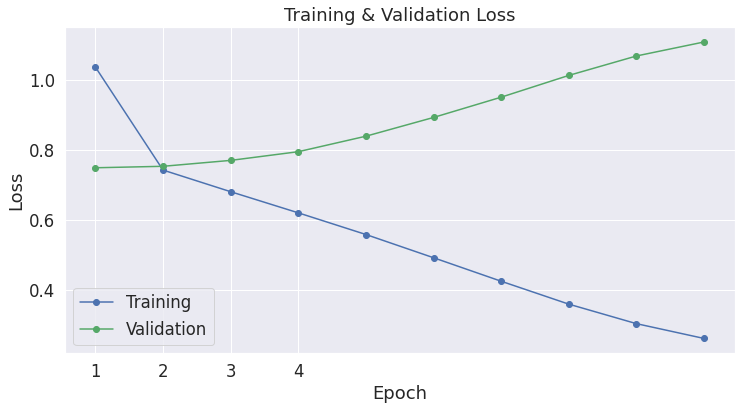

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [24]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [57]:
!whereami

/bin/bash: whereami: command not found


In [49]:
!ls -l --block-size=K ./model_save/

total 499888K
-rw-r--r-- 1 root root      1K Mar  9 17:59 added_tokens.json
-rw-r--r-- 1 root root      1K Mar  9 17:59 config.json
-rw-r--r-- 1 root root      1K Mar  9 17:59 generation_config.json
-rw-r--r-- 1 root root    446K Mar  9 17:59 merges.txt
-rw-r--r-- 1 root root 498442K Mar  9 17:59 pytorch_model.bin
-rw-r--r-- 1 root root      1K Mar  9 17:59 special_tokens_map.json
-rw-r--r-- 1 root root      1K Mar  9 17:59 tokenizer_config.json
-rw-r--r-- 1 root root    976K Mar  9 17:59 vocab.json


In [50]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Mar  9 17:59 ./model_save/pytorch_model.bin


In [51]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


In [25]:
torch.save(model.state_dict(), 'model.pth')

# Generate Text

In [26]:
model.eval()

prompt = "<|startoftext|>Michael:"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 500,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 13256,    25]], device='cuda:0')
0: Michael: Ok, let's put it this way.  A company can describe their internship as 'full of exciting experiences,' but in fact, what they're not telling you is that they only had one.  There's a lot more.  'A funhouse at night.  Offers high caliber acting.'  It's not hard to find an intern.  And that's a wave of yours.  Now, what, if I were you, who would write the internship, and I took it in another place, and I had to literally read the transcripts, or I would e-mail you e-mail you, and you would not understand what I was doing.


1: Michael: Okay... oh, a... Holly: Oh, here he is. Michael: Here he is. This is his desk. He just loves his desk. Holly: I know. For who it is really, really, nice. Michael: It is his desk. Holly: I really think he would love that. Michael: Is he good at sales? Is he the best salesman I've ever seen? 'I say, I say, I say, I'll sit at your desk. Michael Scott Paper Company.' Holly: That is so sweet... Michae

These aren't bad at all!
